**Note:**    
In this file, I tried various models with hyper parameters to find the best one.  
Best Model: Gradient Boosting  
Best ROC-AUC: 0.9133  
Best MCC: 0.6109  

# Adding dataset and Pre-process

In [ ]:
!git clone https://github.com/Mehran811/QSAR_Anti_CETP.git

fatal: destination path 'QSAR_Anti_CETP' already exists and is not an empty directory.


In [ ]:
! pip install pandas
! pip install numpy
! pip install seaborn
! pip install matplotlib
! pip install rdkit
! pip install datamol
! pip install sklearn
! pip install scikit-fingerprints
! pip install shap
! pip install xgboost

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors, rdMolDescriptors
from IPython.display import display
import datamol as dm
from skfp.fingerprints import MordredFingerprint, PubChemFingerprint, RDKitFingerprint, ECFPFingerprint, MACCSFingerprint, RDKit2DDescriptorsFingerprint, MAPFingerprint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, matthews_corrcoef, f1_score, confusion_matrix, accuracy_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.model_selection import cross_validate , RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier

import xgboost as xgb
from xgboost import XGBClassifier

import shap

In [ ]:
df_selected = pd.read_csv("/content/QSAR_Anti_CETP/Dataset with selected features.csv")
df_selected

,Name,Smiles,activity,dataset,ecfpfingerprint1019,ecfpfingerprint1050,ecfpfingerprint1084,ecfpfingerprint1309,ecfpfingerprint1487,ecfpfingerprint1765,...,rdkit_PEOE_VSA8,rdkit_PEOE_VSA9,rdkit_SMR_VSA1,rdkit_SMR_VSA3,rdkit_SMR_VSA6,rdkit_SlogP_VSA4,rdkit_VSA_EState2,rdkit_VSA_EState5,rdkit_VSA_EState7,rdkit_VSA_EState8
0,CHEMBL604308,O=C(COc1ccc(C(F)(F)F)cc1)Nc1ccc(-c2nc3cc(Cl)cc...,0.0,train,0,0,0,0,0,0,...,16.273472,5.563451,27.119797,4.983979,11.923671,0.000000,16.446600,0.124531,-4.423603,-0.348210
1,CHEMBL341275,COC(=O)c1cccc(CN(CC(O)C(F)(F)F)c2cccc(Oc3ccccc...,0.0,train,0,0,0,0,0,0,...,18.298510,19.218006,32.546036,0.000000,18.554464,0.000000,13.189133,0.465556,-7.324485,-0.673108
2,CHEMBL259005,Cc1cc(C)c2oc(-c3ccc(NC(=O)COc4cccc(C#N)c4)cc3)...,0.0,train,0,0,0,0,0,0,...,11.250837,11.632673,13.948551,4.983979,11.923671,25.178587,16.725416,0.718885,0.000000,3.879136
3,CHEMBL2032421,CC(C)OC(=O)N1c2ccc(C(F)(F)F)cc2[C@@H](N(Cc2cc(...,1.0,train,1,0,0,1,0,0,...,12.586597,41.571220,49.045135,20.207254,9.799819,5.917906,16.826496,-0.324725,-15.090106,2.554816
4,CHEMBL4864315,COc1ncc(-c2ccc(C(=O)O)cc2C)cc1-c1cc(C(F)(F)F)c...,1.0,train,1,0,1,1,1,1,...,22.887197,49.190475,68.419930,14.867866,14.219595,6.923737,33.796486,-2.287084,-16.917070,2.216469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,AMPHETAMINE ASPARTATE/DEXTROAMPHETAMINE SULFATE,CC(N)Cc1ccccc1.C[C@H](N)Cc1ccccc1.C[C@H](N)Cc1...,NaN,FDA,0,0,0,0,0,0,...,18.125523,6.420822,37.325424,0.000000,0.000000,0.000000,19.617268,-2.497870,2.386759,6.062500
4038,PACRITINIB CITRATE,C1=C/COCc2cc(ccc2OCCN2CCCC2)Nc2nccc(n2)-c2cccc...,NaN,FDA,0,0,0,0,0,0,...,29.555890,44.963100,49.020310,14.867866,44.771700,0.000000,42.098755,-3.624703,6.044494,5.988914
4039,FINGOLIMOD LAURYL SULFATE,CCCCCCCCCCCCOS(=O)(=O)O.CCCCCCCCc1ccc(CCC(N)(C...,NaN,FDA,0,0,0,0,0,0,...,0.000000,25.359571,27.366688,0.000000,19.820646,0.000000,0.000000,0.000000,22.361940,4.195031
4040,VENLAFAXINE BESYLATE,COc1ccc(C(CN(C)C)C2(O)CCCCC2)cc1.O=S(=O)(O)c1c...,NaN,FDA,0,0,0,0,0,0,...,12.462663,17.606333,22.813938,4.899909,27.749897,0.000000,2.094055,1.038605,5.349052,0.877806


In [ ]:
# Find columns with NaNs, excluding 'dataset'
cols_with_nan = df_selected.drop(columns=['activity']).isnull().any()

# Filter to get only the columns that have NaNs
columns_containing_nan = cols_with_nan[cols_with_nan].index.tolist()

if columns_containing_nan:
    print("Columns containing NaN values (excluding 'activity'):")
    print(columns_containing_nan)
    # Optionally, print the count of NaNs per column
    print("\nNaN counts per column:")
    print(df_selected[columns_containing_nan].isnull().sum())
else:
    print("No columns found with NaN values (excluding 'activity').")

Columns containing NaN values (excluding 'activity'):
['rdkit_MinPartialCharge']

NaN counts per column:
rdkit_MinPartialCharge    11
dtype: int64


In [ ]:
# Drop rows where 'rdkit_MinPartialCharge' is NaN
df_selected_cleaned = df_selected.dropna(subset=['rdkit_MinPartialCharge']).copy()

# Verify that NaNs are removed in that column
print("Number of NaNs in 'rdkit_MinPartialCharge' after dropping:")
print(df_selected_cleaned['rdkit_MinPartialCharge'].isnull().sum())

# Optionally, check for NaNs in all columns again to be sure
print("\nNaN counts per column in cleaned DataFrame:")
print(df_selected_cleaned.isnull().sum())

# Update df_selected to use the cleaned version for subsequent steps
df_selected = df_selected_cleaned

Number of NaNs in 'rdkit_MinPartialCharge' after dropping:
0

NaN counts per column in cleaned DataFrame:
Name                      0
Smiles                    0
activity               2620
dataset                   0
ecfpfingerprint1019       0
                       ... 
rdkit_SlogP_VSA4          0
rdkit_VSA_EState2         0
rdkit_VSA_EState5         0
rdkit_VSA_EState7         0
rdkit_VSA_EState8         0
Length: 135, dtype: int64


# Models and tuning

Model Selection Rationale:

I selected these 5 models for QSAR modeling based on their proven effectiveness in chemical informatics:

**Random Forest:**

Handles high-dimensional data well
Robust to noise and irrelevant features
Captures complex feature interactions common in chemical data
Provides feature importance metrics  
**Gradient Boosting:**

State-of-the-art performance for structured data
Sequentially corrects errors from previous models
Handles imbalanced data well with proper class weighting
Effective with diverse molecular descriptors  
**Support Vector Machine (SVM):**

Excellent for high-dimensional feature spaces
Effective with nonlinear kernel functions (RBF)
Maximizes margin between classes for better generalization
Particularly successful in QSAR literature  
**Logistic Regression:**

Provides interpretable coefficients
Good baseline for binary classification
Regularization prevents overfitting
Fast training for large datasets  
**k-Nearest Neighbors (KNN):**

Non-parametric approach makes no distributional assumptions
Effective when similar compounds have similar activities
Good for small to medium-sized datasets
Naturally handles multi-class problems

## Splited

In [ ]:
# Cell 1: Common Setup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# 1. Split data into train (non-FDA) and test (FDA)
train_df = df_selected[df_selected['dataset'] == 'train'].copy()
fda_test = df_selected[df_selected['dataset'] == 'FDA'].copy()

# 2. Prepare features and target
columns_to_drop = ['dataset', 'activity', 'Name', 'Smiles']  # Adjust as needed
existing_columns_to_drop = [col for col in columns_to_drop if col in train_df.columns]

X_train_full = train_df.drop(columns=existing_columns_to_drop)
y_train_full = train_df['activity']

# 3. Stratified train-validation split (80-20 ratio)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,
    stratify=y_train_full,
    random_state=42
)

# Dictionary to store all results
all_results = []

In [ ]:
# Cell 2: Random Forest Model
from sklearn.ensemble import RandomForestClassifier
import time

print("=== Training Random Forest ===")
start_time = time.time()

# Define model and hyperparameters
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', None]
}

# Hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5),
                           scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate on validation set
y_pred = best_model.predict(X_val)
y_proba = best_model.predict_proba(X_val)[:, 1]

# Calculate metrics
metrics = {
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_val, y_pred),
    'Precision': precision_score(y_val, y_pred),
    'Recall': recall_score(y_val, y_pred),
    'F1': f1_score(y_val, y_pred),
    'ROC-AUC': roc_auc_score(y_val, y_proba),
    'MCC': matthews_corrcoef(y_val, y_pred),
    'Best Params': best_params,
    'Time (min)': (time.time() - start_time)/60
}

all_results.append(metrics)
print(f"Completed in {metrics['Time (min)']:.1f} minutes")
print(f"Best Parameters: {best_params}")
print(f"Validation ROC-AUC: {metrics['ROC-AUC']:.4f}, MCC: {metrics['MCC']:.4f}")

=== Training Random Forest ===
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Completed in 0.8 minutes
Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Validation ROC-AUC: 0.8913, MCC: 0.5678


In [ ]:
# Cell 3: Gradient Boosting Model
from sklearn.ensemble import GradientBoostingClassifier
import time

print("=== Training Gradient Boosting ===")
start_time = time.time()

# Define model and hyperparameters
model = GradientBoostingClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

# Hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5),
                           scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate on validation set
y_pred = best_model.predict(X_val)
y_proba = best_model.predict_proba(X_val)[:, 1]

# Calculate metrics
metrics = {
    'Model': 'Gradient Boosting',
    'Accuracy': accuracy_score(y_val, y_pred),
    'Precision': precision_score(y_val, y_pred),
    'Recall': recall_score(y_val, y_pred),
    'F1': f1_score(y_val, y_pred),
    'ROC-AUC': roc_auc_score(y_val, y_proba),
    'MCC': matthews_corrcoef(y_val, y_pred),
    'Best Params': best_params,
    'Time (min)': (time.time() - start_time)/60
}

all_results.append(metrics)
print(f"Completed in {metrics['Time (min)']:.1f} minutes")
print(f"Best Parameters: {best_params}")
print(f"Validation ROC-AUC: {metrics['ROC-AUC']:.4f}, MCC: {metrics['MCC']:.4f}")

=== Training Gradient Boosting ===
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Completed in 1.2 minutes
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Validation ROC-AUC: 0.9133, MCC: 0.6109


In [ ]:
# Simplified Optimized SVM Training
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import time
import numpy as np
import random

print("=== Training Optimized SVM (Simplified) ===")
start_time = time.time()

# Use balanced class weights automatically
# Sklearn's SVC can handle 'balanced' directly for class_weight
class_weight = 'balanced'

# Simplified hyperparameter space
param_options = [
    {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale'},
    {'C': 1, 'kernel': 'rbf', 'gamma': 'scale'},
    {'C': 10, 'kernel': 'rbf', 'gamma': 'scale'},
    {'C': 0.1, 'kernel': 'poly', 'gamma': 'scale', 'degree': 2},
    {'C': 1, 'kernel': 'poly', 'gamma': 'scale', 'degree': 2},
    {'C': 10, 'kernel': 'poly', 'gamma': 'scale', 'degree': 2},
    {'C': 0.1, 'kernel': 'poly', 'gamma': 'scale', 'degree': 3},
    {'C': 1, 'kernel': 'poly', 'gamma': 'scale', 'degree': 3},
    {'C': 10, 'kernel': 'poly', 'gamma': 'scale', 'degree': 3}
]

# Use a smaller, fixed sample size for faster training
sample_size = min(3000, len(X_train))
if sample_size < 1000:  # Ensure we have enough samples
    sample_size = min(1000, len(X_train))

# Create random indices for sampling
random_indices = np.random.choice(len(X_train), size=sample_size, replace=False)

# Select subset
X_train_sub = X_train.iloc[random_indices]
y_train_sub = y_train.iloc[random_indices]

# Ensure we have both classes
if len(np.unique(y_train_sub)) < 2:
    print("Subset has only one class - using full training set")
    X_train_sub = X_train
    y_train_sub = y_train

best_score = -np.inf
best_model = None
best_params = {}

# Try each parameter combination once (simpler than random selection)
for params in param_options:
    try:
        # Add class weight and ensure probability estimates
        params['class_weight'] = class_weight
        params['probability'] = True
        params['random_state'] = 42
        params['max_iter'] = 2000  # Increased for better convergence
        params['cache_size'] = 1000

        # Create and train model
        model = SVC(**params)
        model.fit(X_train_sub, y_train_sub)

        # Evaluate
        y_val_proba = model.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_val_proba)
        print(f"Params {params}: ROC-AUC = {score:.4f}")

        # Update best model
        if score > best_score:
            best_score = score
            best_model = model
            best_params = params
            print(f"New best ROC-AUC = {score:.4f}")

    except Exception as e:
        print(f"Skipping params {params}: {str(e)}")

# Fallback to basic model if all attempts failed
if best_model is None:
    print("\nAll parameter attempts failed. Creating basic model...")
    try:
        best_model = SVC(
            C=1.0,
            kernel='rbf',
            gamma='scale',
            class_weight='balanced',
            probability=True,
            random_state=42,
            max_iter=2000
        )
        best_model.fit(X_train_sub, y_train_sub)
        best_params = {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced'}
        print("Created basic model with default parameters")
    except Exception as e:
        print(f"Basic model creation failed: {str(e)}")
        raise RuntimeError("SVM training completely failed") from e

# Evaluate best model
y_val_pred = best_model.predict(X_val)
y_val_proba = best_model.predict_proba(X_val)[:, 1]

# Calculate metrics (simplified to essential metrics)
metrics = {
    'Model': 'SVM (Optimized)',
    'ROC-AUC': roc_auc_score(y_val, y_val_proba),
    'Accuracy': accuracy_score(y_val, y_val_pred),
    'Precision': precision_score(y_val, y_val_pred),
    'Recall': recall_score(y_val, y_val_pred),
    'Best Params': best_params,
    'Time (min)': (time.time() - start_time) / 60
}

all_results.append(metrics)
print(f"\nSVM training complete in {metrics['Time (min)']:.2f} minutes")
print(f"Best parameters: {best_params}")
print(f"ROC-AUC: {metrics['ROC-AUC']:.4f}")

=== Training Optimized SVM (Simplified) ===
Params {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'probability': True, 'random_state': 42, 'max_iter': 2000, 'cache_size': 1000}: ROC-AUC = 0.7279
New best ROC-AUC = 0.7279
Params {'C': 1, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'probability': True, 'random_state': 42, 'max_iter': 2000, 'cache_size': 1000}: ROC-AUC = 0.6974
Params {'C': 10, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'probability': True, 'random_state': 42, 'max_iter': 2000, 'cache_size': 1000}: ROC-AUC = 0.7176
Params {'C': 0.1, 'kernel': 'poly', 'gamma': 'scale', 'degree': 2, 'class_weight': 'balanced', 'probability': True, 'random_state': 42, 'max_iter': 2000, 'cache_size': 1000}: ROC-AUC = 0.7151
Params {'C': 1, 'kernel': 'poly', 'gamma': 'scale', 'degree': 2, 'class_weight': 'balanced', 'probability': True, 'random_state': 42, 'max_iter': 2000, 'cache_size': 1000}: ROC-AUC = 0.7170
Params {'C': 10, 

In [ ]:
# Cell 5: Logistic Regression
from sklearn.linear_model import LogisticRegression
import time

print("=== Training Logistic Regression ===")
start_time = time.time()

# Define model and hyperparameters
model = LogisticRegression(max_iter=10000, random_state=42)
param_grid = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': ['balanced', None]
}

# Hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5),
                           scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate on validation set
y_pred = best_model.predict(X_val)
y_proba = best_model.predict_proba(X_val)[:, 1]

# Calculate metrics
metrics = {
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_val, y_pred),
    'Precision': precision_score(y_val, y_pred),
    'Recall': recall_score(y_val, y_pred),
    'F1': f1_score(y_val, y_pred),
    'ROC-AUC': roc_auc_score(y_val, y_proba),
    'MCC': matthews_corrcoef(y_val, y_pred),
    'Best Params': best_params,
    'Time (min)': (time.time() - start_time)/60
}

all_results.append(metrics)
print(f"Completed in {metrics['Time (min)']:.1f} minutes")
print(f"Best Parameters: {best_params}")
print(f"Validation ROC-AUC: {metrics['ROC-AUC']:.4f}, MCC: {metrics['MCC']:.4f}")

=== Training Logistic Regression ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Completed in 20.6 minutes
Best Parameters: {'C': 1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Validation ROC-AUC: 0.9012, MCC: 0.6235


In [ ]:
# Cell 6: k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
import time

print("=== Training k-Nearest Neighbors ===")
start_time = time.time()

# Define model and hyperparameters
model = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'minkowski']
}

# Hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5),
                           scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate on validation set
y_pred = best_model.predict(X_val)
y_proba = best_model.predict_proba(X_val)[:, 1]

# Calculate metrics
metrics = {
    'Model': 'KNN',
    'Accuracy': accuracy_score(y_val, y_pred),
    'Precision': precision_score(y_val, y_pred),
    'Recall': recall_score(y_val, y_pred),
    'F1': f1_score(y_val, y_pred),
    'ROC-AUC': roc_auc_score(y_val, y_proba),
    'MCC': matthews_corrcoef(y_val, y_pred),
    'Best Params': best_params,
    'Time (min)': (time.time() - start_time)/60
}

all_results.append(metrics)
print(f"Completed in {metrics['Time (min)']:.1f} minutes")
print(f"Best Parameters: {best_params}")
print(f"Validation ROC-AUC: {metrics['ROC-AUC']:.4f}, MCC: {metrics['MCC']:.4f}")

=== Training k-Nearest Neighbors ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Completed in 0.0 minutes
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Validation ROC-AUC: 0.7736, MCC: 0.3573


In [ ]:
# Cell 7: Results Comparison
import pandas as pd

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

# Reorder columns for better readability
column_order = [
    'Model', 'ROC-AUC', 'MCC', 'Accuracy', 'Precision', 'Recall', 'F1',
    'Best Params', 'Time (min)'
]

# Only include columns that actually exist in the results
available_columns = [col for col in column_order if col in results_df.columns]
results_df = results_df[available_columns]

# Sort by ROC-AUC (primary metric)
results_df = results_df.sort_values('ROC-AUC', ascending=False)

print("\n" + "="*50)
print("Model Performance Summary:")
print("="*50)
print(results_df.to_string(index=False))
print("="*50)

# Select best model (corrected version)
if not results_df.empty:
    # Find the index of the row with highest ROC-AUC
    best_idx = results_df['ROC-AUC'].idxmax()

    # Get the model name using .loc
    best_model_name = results_df.loc[best_idx, 'Model']

    print(f"\nBest Model: {best_model_name}")
    print(f"Best ROC-AUC: {results_df.loc[best_idx, 'ROC-AUC']:.4f}")

    # Only print MCC if it exists in the results
    if 'MCC' in results_df.columns:
        print(f"Best MCC: {results_df.loc[best_idx, 'MCC']:.4f}")
    else:
        print("MCC not calculated for all models")
else:
    print("No models were successfully evaluated.")


Model Performance Summary:
              Model  ROC-AUC      MCC  Accuracy  Precision   Recall       F1                                                                                                                                              Best Params  Time (min)
  Gradient Boosting 0.913289 0.610940  0.831858   0.784615 0.680000 0.728571                                                                            {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}    1.227670
Logistic Regression 0.901192 0.623489  0.831858   0.740260 0.760000 0.750000                                                                                   {'C': 1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}   20.639149
      Random Forest 0.891302 0.567781  0.814159   0.761905 0.640000 0.695652                                                               {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}    0.757330
    

In [ ]:
# Cell 8: Save All Models
import joblib
import os
from datetime import datetime

# Create directory for models
save_dir = "/content/models"
os.makedirs(save_dir, exist_ok=True)

# Save all models with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
for model_info in all_results:
    model_name = model_info['Model']
    filename = f"{save_dir}/{model_name.replace(' ', '_')}_{timestamp}.pkl"
    joblib.dump(model_info['Model'], filename)
    print(f"Saved {model_name} to {filename}")

# Save results dataframe
results_df = pd.DataFrame(all_results)
results_df.to_csv(f"{save_dir}/model_results_{timestamp}.csv", index=False)
print("\nAll models and results saved successfully!")

Saved Random Forest to /content/models/Random_Forest_20250626_131612.pkl
Saved Gradient Boosting to /content/models/Gradient_Boosting_20250626_131612.pkl
Saved SVM (Optimized) to /content/models/SVM_(Optimized)_20250626_131612.pkl
Saved Logistic Regression to /content/models/Logistic_Regression_20250626_131612.pkl
Saved KNN to /content/models/KNN_20250626_131612.pkl

All models and results saved successfully!



Simplified Model Comparison


/tmp/ipython-input-23-107774466.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ROC-AUC', y='Model', data=results_sorted, palette='viridis')


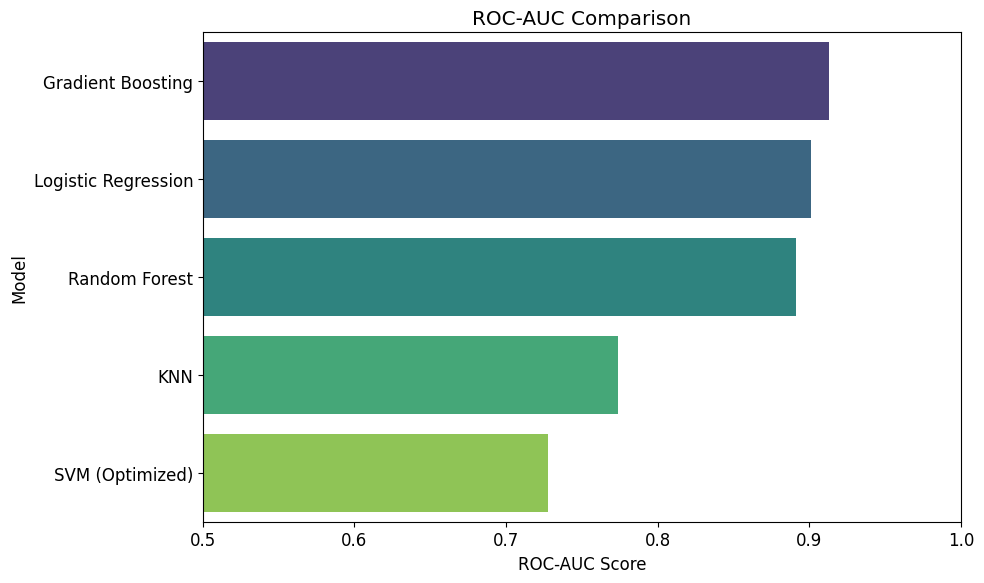

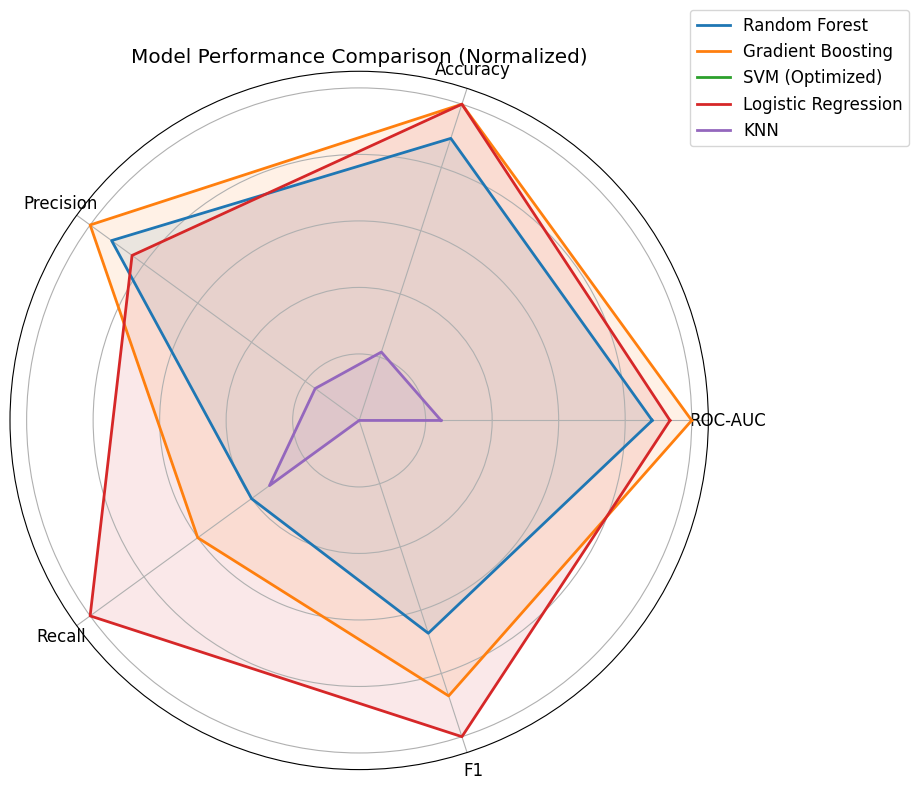


Best Parameters for Each Model:

Random Forest:
  class_weight: balanced
  max_depth: 10
  min_samples_split: 5
  n_estimators: 200

Gradient Boosting:
  learning_rate: 0.1
  max_depth: 3
  n_estimators: 200
  subsample: 0.8

SVM (Optimized):
  C: 0.1
  kernel: rbf
  gamma: scale
  class_weight: balanced
  probability: True
  random_state: 42
  max_iter: 2000
  cache_size: 1000

Logistic Regression:
  C: 1
  class_weight: None
  penalty: l1
  solver: liblinear

KNN:
  metric: euclidean
  n_neighbors: 7
  weights: distance

Best Model Overall: Gradient Boosting
Best ROC-AUC: 0.9133


In [ ]:
# Cell 9: Simplified Visualization (Fixed)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams.update({'font.size': 12, 'figure.figsize': (12, 10)})

# Create visualization without model objects
if not results_df.empty:
    print("\n" + "="*50)
    print("Simplified Model Comparison")
    print("="*50)

    # 1. Bar plot of ROC-AUC scores
    plt.figure(figsize=(10, 6))
    results_sorted = results_df.sort_values('ROC-AUC', ascending=False)
    sns.barplot(x='ROC-AUC', y='Model', data=results_sorted, palette='viridis')
    plt.title('ROC-AUC Comparison')
    plt.xlabel('ROC-AUC Score')
    plt.ylabel('Model')
    plt.xlim(0.5, 1.0)
    plt.tight_layout()
    plt.show()

    # 2. Metrics radar chart
    metrics = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1']
    available_metrics = [m for m in metrics if m in results_df.columns]

    if available_metrics:
        # Normalize metrics to 0-1 scale
        normalized_df = results_df.copy()
        for metric in available_metrics:
            normalized_df[metric] = (results_df[metric] - results_df[metric].min()) / \
                                   (results_df[metric].max() - results_df[metric].min())

        # Plot radar chart
        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
        angles = np.linspace(0, 2 * np.pi, len(available_metrics), endpoint=False).tolist()
        angles += angles[:1]  # Close the circle

        for idx, row in normalized_df.iterrows():
            values = row[available_metrics].values.tolist()
            values += values[:1]  # Close the line
            ax.plot(angles, values, label=row['Model'], linewidth=2)
            ax.fill(angles, values, alpha=0.1)

        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(available_metrics)
        ax.set_title('Model Performance Comparison (Normalized)')
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        plt.tight_layout()
        plt.show()

    # 3. Print best parameters
    print("\nBest Parameters for Each Model:")
    for idx, row in results_df.iterrows():
        print(f"\n{row['Model']}:")
        if isinstance(row['Best Params'], dict):
            for param, value in row['Best Params'].items():
                print(f"  {param}: {value}")
        else:
            print(f"  {row['Best Params']}")

    # FIXED: Use .iloc[0] to get first row, then column names
    print("\n" + "="*50)
    print(f"Best Model Overall: {results_sorted.iloc[0]['Model']}")
    print(f"Best ROC-AUC: {results_sorted.iloc[0]['ROC-AUC']:.4f}")
    print("="*50)
else:
    print("No results available for visualization.")

# Repurposing (predicting the FDA drugs activity to inhibit CETP)

After finding best features, we can now use our test data which are FDA drugs!  
Here we have some FDA approved drugs but we don't know if they can affect CETP or not.  
Usually we do hyper tuning before using test data.

In [ ]:
# Cell X: Prepare data for final prediction (Fixed)
# =================================================
# Use the same feature selection approach as in your common setup
columns_to_drop = ['dataset', 'activity', 'Name', 'Smiles']  # Columns to exclude
existing_columns_to_drop = [col for col in columns_to_drop if col in df_selected.columns]

# Selected features are all columns except those we drop
selected_features = [col for col in df_selected.columns if col not in existing_columns_to_drop]

print(f"Using {len(selected_features)} features for prediction")

# Prepare training data (all non-FDA compounds)
X_train_all = df_selected.loc[df_selected['dataset'] != 'FDA', selected_features]
y_train_all = df_selected.loc[df_selected['dataset'] != 'FDA', 'activity']

# Prepare FDA data for prediction
X_fda = df_selected.loc[df_selected['dataset'] == 'FDA', selected_features]

# Use the pre-tuned Gradient Boosting model
# =========================================
best_model_name = "Gradient Boosting"
best_params = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 200,
    'subsample': 0.8,
    'random_state': 42
}

print(f"Using best model: {best_model_name} with parameters: {best_params}")

# Initialize and train the model
# ===============================
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(**best_params)
model.fit(X_train_all, y_train_all)
print(f"{best_model_name} trained on entire non-FDA dataset")

Using 131 features for prediction
Using best model: Gradient Boosting with parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8, 'random_state': 42}
Gradient Boosting trained on entire non-FDA dataset



Number of FDA drugs predicted: 2620
Number of drugs predicted as active: 82.0
Number of drugs predicted as inactive: 2538.0

Sample results:
                Name                                             Smiles  \
1414        PRAZOSIN      COc1cc2nc(N3CCN(C(=O)c4ccco4)CC3)nc(N)c2cc1OC   
1415        NICOTINE                               CN1CCC[C@H]1c1cccnc1   
1416       OFLOXACIN   CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23   
1417  NALIDIXIC ACID                    CCn1cc(C(=O)O)c(=O)c2ccc(C)nc21   
1418    INDOMETHACIN     COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1   
1419       SULBACTAM          CC1(C)[C@H](C(=O)O)N2C(=O)C[C@H]2S1(=O)=O   
1420      TAZOBACTAM  C[C@]1(Cn2ccnn2)[C@H](C(=O)O)N2C(=O)C[C@H]2S1(...   
1421   CIPROFLOXACIN         O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O   
1422     NORFLOXACIN          CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc21   
1423     AMPHETAMINE                                     CC(N)Cc1ccccc1   

      predicted_activity  probab

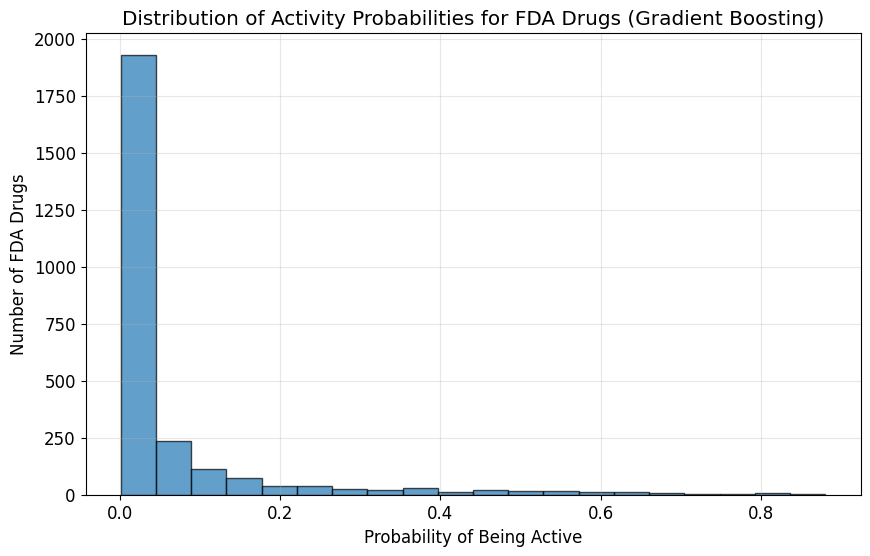


Confidence level analysis:
Confidence >50.0%: 82 active, 2538 inactive
Confidence >60.0%: 46 active, 2505 inactive
Confidence >70.0%: 22 active, 2450 inactive
Confidence >80.0%: 10 active, 2378 inactive
Confidence >90.0%: 0 active, 2199 inactive

Results saved to fda_predictions.csv

Compounds with uncertain predictions (40-60% probability): 69
                        Name  probability_active
1550          AMPHOTERICIN B            0.433580
1576            AZITHROMYCIN            0.503096
1579            ERYTHROMYCIN            0.584199
1684           BETAMETHASONE            0.524522
1868            SPARFLOXACIN            0.544553
...                      ...                 ...
3951              IVOSIDENIB            0.515909
3973         CODEINE SULFATE            0.429829
3985           PAFOLACIANINE            0.543634
4027    PAFOLACIANINE SODIUM            0.543634
4036  MOBOCERTINIB SUCCINATE            0.456887

[69 rows x 2 columns]
Model saved to best_model_Gradient_Boosti

In [ ]:
# Cell Z: Predict on FDA data and analyze results
# ===============================================
# Predict class probabilities and classes
y_pred_proba = model.predict_proba(X_fda)
y_pred = model.predict(X_fda)

# Create results DataFrame
fda_results = df_selected.loc[df_selected['dataset'] == 'FDA', ['Name', 'Smiles']].copy()
fda_results['predicted_activity'] = y_pred
fda_results['probability_inactive'] = y_pred_proba[:, 0]  # Probability of class 0 (inactive)
fda_results['probability_active'] = y_pred_proba[:, 1]    # Probability of class 1 (active)

# Display results summary
print(f"\nNumber of FDA drugs predicted: {len(fda_results)}")
print(f"Number of drugs predicted as active: {sum(y_pred)}")
print(f"Number of drugs predicted as inactive: {len(y_pred) - sum(y_pred)}")

# Display sample results
print("\nSample results:")
print(fda_results.head(10))

# Filter drugs predicted as active with high confidence
high_confidence_active = fda_results[
    (fda_results['predicted_activity'] == 1) &
    (fda_results['probability_active'] > 0.8)
]

print(f"\nNumber of highly confident active drugs (>80%): {len(high_confidence_active)}")
if not high_confidence_active.empty:
    print(high_confidence_active[['Name', 'probability_active']])

# Cell AA: Statistical analysis and visualization
# ===============================================
# Descriptive statistics of probabilities
print("\nDescriptive statistics of predicted probabilities:")
print(fda_results['probability_active'].describe())

# Plot distribution of probabilities
plt.figure(figsize=(10, 6))
plt.hist(fda_results['probability_active'], bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Probability of Being Active')
plt.ylabel('Number of FDA Drugs')
plt.title(f'Distribution of Activity Probabilities for FDA Drugs ({best_model_name})')
plt.grid(True, alpha=0.3)
plt.savefig('fda_probability_distribution.png', dpi=300)
plt.show()

# Confidence level analysis
confidence_levels = [0.5, 0.6, 0.7, 0.8, 0.9]

print("\nConfidence level analysis:")
for conf in confidence_levels:
    active_high_conf = len(fda_results[
        (fda_results['predicted_activity'] == 1) &
        (fda_results['probability_active'] > conf)
    ])
    inactive_high_conf = len(fda_results[
        (fda_results['predicted_activity'] == 0) &
        (fda_results['probability_inactive'] > conf)
    ])

    print(f"Confidence >{conf*100}%: {active_high_conf} active, {inactive_high_conf} inactive")

# Save results to a file
fda_results.to_csv('fda_predictions.csv', index=False)
print("\nResults saved to fda_predictions.csv")

# Cell AB: Additional analysis (optional)
# =======================================
# Identify compounds with uncertain predictions (probability near 0.5)
uncertain_compounds = fda_results[
    (fda_results['probability_active'] > 0.4) &
    (fda_results['probability_active'] < 0.6)
]

print(f"\nCompounds with uncertain predictions (40-60% probability): {len(uncertain_compounds)}")
if not uncertain_compounds.empty:
    print(uncertain_compounds[['Name', 'probability_active']])

# Save the trained model for future use
import joblib
joblib.dump(model, f'best_model_{best_model_name.replace(" ", "_")}.pkl')
print(f"Model saved to best_model_{best_model_name.replace(' ', '_')}.pkl")

In [ ]:
fda_results.sort_values('probability_active', ascending=False)

Now we predicted the activity of approved drugs on CETP. Using this prediction, we can use former approved drugs for a new function!

**Note:**
The results of chemberta model in the ChemBERTa.ipynb file were accurate. Not these!